In [1]:
# comp_name = CSV.read("data/constituents_csv.csv")
# for i in 1:((size(comp_name))[1]-1)
#     #println("https://query1.finance.yahoo.com/v7/finance/download/",comp_name[i,1],"?period1=946706400&period2=1514786400&interval=1mo&events=history&crumb=UB6zx5WdF5I")
# end

In [1]:
# HELPER FUNCTION TO CALCULATE RATIO OF RETURN
# ratio of return in a monthly base
function get_monthly_return(csv_data)
    montly_return = Float64[]
    for i in 1:((size(csv_data))[1]-1)
        append!(montly_return, (csv_data[i+1,5]-csv_data[i,5])/csv_data[i,5])
    end  
    return montly_return
end;    

In [2]:
using CSV, LinearAlgebra
# remove those files(not long enough)
data_files = readdir("top30")
total_monthly_return = zeros(215)
valid_data = zeros(216)

for i in data_files
    file_path = string("top30/", i)
    csv_data = CSV.read(file_path) 
    csv_length = (size(csv_data))[1]
    # check all csv has the same length (no new/removed S&P 500)
    if csv_length != 216
        print(file_path, ": ")
        println(csv_length)
    else
        valid_data = hcat(valid_data, csv_data[:,5])        
        total_monthly_return = hcat(total_monthly_return, get_monthly_return(csv_data))
    end
end    

valid_data = valid_data[:, 2:end]
total_monthly_return = total_monthly_return[:, 2:end]
;

top30/ABBV.csv: 60
top30/ADS.csv: 199
top30/AIZ.csv: 167
top30/ALGN.csv: 204
top30/AVGO.csv: 101
top30/AYI.csv: 193
top30/CBOE.csv: 91
top30/CME.csv: 181
top30/DG.csv: 98
top30/DISCA.csv: 150
top30/EQIX.csv: 209
top30/FTV.csv: 18
top30/GOOGL.csv: 161
top30/HCA.csv: 82
top30/HII.csv: 82
top30/HLT.csv: 49
top30/KHC.csv: 30
top30/KMI.csv: 83
top30/LYB.csv: 93
top30/MDLZ.csv: 199
top30/NAVI.csv: 45
top30/NLSN.csv: 84
top30/NRG.csv: 169
top30/NWSA.csv: 55
top30/PM.csv: 118
top30/PPG.csv: 2
top30/RTN.csv: 276
top30/STX.csv: 181
top30/SYF.csv: 42
top30/TDG.csv: 142
top30/TEL.csv: 127
top30/UA.csv: 30
top30/V.csv: 118
top30/WRK.csv: 31
top30/WYNN.csv: 183


In [7]:
num_time_period = size(total_monthly_return)[1]
num_stock = size(total_monthly_return)[2]

# mean of monthly return of a stock
using Statistics
expected_monthly_return = Float64[]
for i in 1:size(total_monthly_return)[2]
    push!(expected_monthly_return, mean(total_monthly_return[:,i]))
end
expected_monthly_return
;

In [9]:
# Σ
# convolution between stocks
cov_matrix = transpose(total_monthly_return)*total_monthly_return./num_time_period
        -expected_monthly_return*transpose(expected_monthly_return)
;

In [10]:
baseline_profit = 0.01
mT = transpose(expected_monthly_return)

using JuMP, Gurobi
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, w[1:num_stock])
@objective(m, Min, dot(w,cov_matrix*w) )
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol = getvalue(w)
;

Academic license - for non-commercial use only
Optimal


In [11]:
# mean of monthly return of a stock
using Statistics

function get_expected_monthly_return(total_monthly_return)
    expected_monthly_return = Float64[]
    for i in 1:size(total_monthly_return)[2]
        push!(expected_monthly_return, mean(total_monthly_return[:,i]))
    end
    return expected_monthly_return
end

function get_cov_matrix(total_monthly_return, expected_monthly_return)
    return transpose(total_monthly_return)*total_monthly_return./size(total_monthly_return)[2]-expected_monthly_return*transpose(expected_monthly_return)
end
;

In [12]:
# US treasurt securities data in %
risk_free = CSV.read("data/risk_free.csv")
risk_free_15 = mean(risk_free[2:180,2])/100

0.03803351955307261

In [13]:
risk_free_10 = mean(risk_free[62:180,2])/100

0.03317899159663869

In [14]:
# US treasurt securities data in %
index_data = CSV.read("data/index.csv")
index_monthly_return_15 = get_monthly_return(index_data[1:180,:])
index_monthly_return_10 = get_monthly_return(index_data[61:180,:])
;

In [15]:
# HELPER FUNCTION TO CALCULATE RATIO OF RETURN
# ratio of return in a monthly base
function get_monthly_return_stock(csv_data)
    montly_return = Float64[]
    for i in 1:((size(csv_data))[1]-1)
        append!(montly_return, (csv_data[i+1,1]-csv_data[i,1])/csv_data[i,1])
    end  
    return montly_return
end;    

In [16]:
using CSV, LinearAlgebra
# remove those files(not long enough)
length_15 = 180-1
total_monthly_return_15 = zeros(length_15)

for i in 1:num_stock
    total_monthly_return_15 = hcat(total_monthly_return_15, get_monthly_return_stock(valid_data[1:180,i]))
end    

total_monthly_return_15 = total_monthly_return_15[:, 2:end]
;

In [17]:
expected_monthly_return_15 = get_expected_monthly_return(total_monthly_return_15)
cov_matrix_15 = get_cov_matrix(total_monthly_return_15, expected_monthly_return_15)
;

In [46]:
# 2000-2015 risk free
baseline_profit = risk_free_15
# baseline_profit = sum(expected_monthly_return_15)/length_15
mT = transpose(expected_monthly_return_15)
cov = cov_matrix_15

using JuMP, Gurobi, Ipopt
# m = Model(solver=GurobiSolver(OutputFlag=0))
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol = getvalue(w)

Optimal


129-element Array{Float64,1}:
  0.05186932254529168 
  0.16377629857886364 
 -0.08037952815913918 
  0.06173161297096315 
 -0.14835368791284317 
 -0.11139669317261398 
 -0.040819809640198726
 -0.07121294863241658 
  0.13270196177667962 
 -0.03268117797920508 
 -0.030053811285878546
  0.041155612813808654
  0.2956681932065273  
  ⋮                   
 -0.1865479119139798  
 -0.14884114897109776 
  0.17602943907232724 
 -0.060165767588734605
  0.24333242537743216 
  0.24597213581153293 
 -0.15717957802805635 
 -0.24061311831532314 
  0.08037110378684333 
  0.09334783456373777 
 -0.016543195945501434
  0.018189029093046812

In [24]:
# 2000-2015 index
baseline_profit = mean(index_monthly_return_15)
# baseline_profit = sum(expected_monthly_return_15)/length_15
mT = transpose(expected_monthly_return_15)
cov = cov_matrix_15

using JuMP, Gurobi, Ipopt
# m = Model(solver=GurobiSolver(OutputFlag=0))
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol = getvalue(w)

Optimal


129-element Array{Float64,1}:
  0.01075847684029391  
  0.06206984272456412  
  0.0053447869982521864
 -0.13835651332957027  
 -0.14337893920207737  
  0.05232097313437602  
 -0.04248178411380556  
 -0.08514915495732697  
  0.03977280969912411  
  0.02132473542620534  
  0.018224483260470412 
 -0.0748842520007391   
 -0.06274895378737814  
  ⋮                    
 -0.13196467501116238  
  0.016293509275095475 
  0.06590061994111036  
  0.147215031740718    
  0.0473210933950309   
  0.03165898617138493  
  0.15354083829267104  
  0.01372999601822003  
  0.039079347624200816 
  0.21512268445811902  
 -0.02558100558663165  
  0.047419947396478944 

In [15]:
# 2000-2015 equally weighted
baseline_profit = mean(expected_monthly_return_15)
# baseline_profit = sum(expected_monthly_return_15)/length_15
mT = transpose(expected_monthly_return_15)
cov = cov_matrix_15

using JuMP, Gurobi, Ipopt
# m = Model(solver=GurobiSolver(OutputFlag=0))
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol = getvalue(w)

Optimal


129-element Array{Float64,1}:
  0.08464572977214564 
  0.2448637137734302  
 -0.14872487631870446 
  0.2212556946681672  
 -0.15231990137304868 
 -0.24192373072407886 
 -0.03949476873643228 
 -0.060102041866337046
  0.20679150383078973 
 -0.07573842431113376 
 -0.06854460404709965 
  0.13367061216466933 
  0.5814231117810164  
  ⋮                   
 -0.23006544043490812 
 -0.28049791041999406 
  0.26383174431214773 
 -0.2255040721964453  
  0.39960620491083143 
  0.41683738915811247 
 -0.4049073667509396  
 -0.4433930258502831  
  0.11329174533264133 
 -0.003739491218092218
 -0.009337629527281052
 -0.005115879027862329

In [16]:
using CSV, LinearAlgebra
# remove those files(not long enough)
length_10 = 180-60-1
total_monthly_return_10 = zeros(length_10)

for i in 1:num_stock
    total_monthly_return_10 = hcat(total_monthly_return_10, get_monthly_return_stock(valid_data[61:180,i]))
end    

total_monthly_return_10 = total_monthly_return_10[:, 2:end]

119×129 Array{Float64,2}:
  0.16671     0.0277968   -0.00413227  …   0.0346009    0.0524272 
 -0.0711101  -0.0435726    0.019917       -0.0321192    0.0621157 
 -0.134629    0.0696457   -0.268104       -0.0783441   -0.0936113 
  0.102607    0.053688     0.103391        0.0308092    0.0922062 
 -0.0741951   0.0709308    0.077078       -0.0817429    0.0154026 
  0.158652    0.0381779    0.0729655   …   0.111765     0.00518436
  0.0994138   0.040117    -0.0187446      -0.00952381  -0.094938  
  0.143314    0.0352217    0.0955131      -0.00819088   0.0217392 
  0.07424    -0.0133248   -0.0117599      -0.140036     0.050816  
  0.177635    0.0534942   -0.0328273       0.103967    -0.0408885 
  0.0600118   0.0304916    0.0462452   …  -0.0465205   -0.0391473 
  0.0503547   0.0541062    0.277372        0.117017     0.0552474 
 -0.0929678   0.0538497    0.0069841      -0.03125     -0.0357792 
  ⋮                                    ⋱                          
 -0.107697   -0.0439482   -0.0903226

In [17]:
expected_monthly_return_10 = get_expected_monthly_return(total_monthly_return_10)
cov_matrix_10 = get_cov_matrix(total_monthly_return_10, expected_monthly_return_10)

129×129 Array{Float64,2}:
 0.00884296   0.000740552   0.00112632   …  0.00208645   0.00266909 
 0.000740552  0.00292671    0.000703173     0.00130032   0.000918648
 0.00112632   0.000703173   0.00688703      0.000985165  0.00104175 
 0.00125489   0.00111254    0.000990962     0.00116032   0.00127278 
 0.000671267  0.000762714   0.000514824     0.000882854  0.000993186
 0.00346078   0.00182497    0.00105365   …  0.00383127   0.0029     
 0.00544862   0.00264863    0.00145819      0.00603374   0.00304246 
 0.003792     0.00232649    0.000546522     0.00372281   0.00352729 
 0.00246195   0.000875993   0.000538722     0.00125441   0.000936933
 0.00365474   0.000679229  -1.7115e-6       0.00338646   0.00257509 
 0.00163581   0.00080084    0.000780148  …  0.00148172   0.00108278 
 0.00301957   0.00117867    0.00100302      0.00237914   0.00213695 
 0.00372811   0.00166286    0.00100846      0.00316325   0.00248489 
 ⋮                                       ⋱                          
 0.00581

In [18]:
# 2005-2015 risk-free
baseline_profit = risk_free_10
# baseline_profit = sum(expected_monthly_return_10)/length_10
mT = transpose(expected_monthly_return_10)
cov = cov_matrix_10

using JuMP, Gurobi, Ipopt
# m = Model(solver=GurobiSolver(OutputFlag=0))
m = Model(solver=IpoptSolver(print_level=0))
@variable(m, w[1:num_stock] >= 0)
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol = getvalue(w)

Optimal


129-element Array{Float64,1}:
 0.3513000737882712   
 3.1526641524578017e-6
 7.632852004787723e-7 
 4.843162111828505e-7 
 3.5399142543062926e-7
 4.980297935475188e-7 
 1.8108471433763118e-7
 5.066284397305023e-7 
 1.015039073987516e-6 
 1.5359367250599971e-6
 8.931495200690383e-7 
 3.624131077506856e-7 
 7.025578340711965e-7 
 ⋮                    
 2.401402854891694e-7 
 3.0348928987405016e-7
 4.901099693347951e-7 
 3.654646969841553e-7 
 1.3446872735355094e-6
 5.451718545200605e-7 
 3.7098778880670495e-7
 3.756291943808678e-7 
 4.557312118498781e-7 
 4.326246868365292e-7 
 3.112136983673777e-7 
 5.040563074214958e-7 

In [19]:
# 2005-2015 index
baseline_profit = mean(index_monthly_return_10)
# baseline_profit = sum(expected_monthly_return_15)/length_15
mT = transpose(expected_monthly_return_10)
cov = cov_matrix_10

using JuMP, Gurobi, Ipopt
# m = Model(solver=GurobiSolver(OutputFlag=0))
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock] >= 0)
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol = getvalue(w)

Optimal


129-element Array{Float64,1}:
 6.0741538532358805e-6
 0.021471926390341838 
 0.0011730301017139682
 2.6226678359631782e-5
 1.0993376977953288e-5
 4.066507989206471e-6 
 1.8752673091247251e-6
 1.7006775680566362e-6
 0.05759166431638319  
 3.95821769789563e-6  
 0.035971296474877346 
 6.079213866356719e-6 
 2.8924707314699687e-6
 ⋮                    
 1.7263371069671088e-6
 3.85434625198967e-6  
 0.000163957730884722 
 1.7036778572277386e-5
 1.0121603116707708e-5
 3.199337666205788e-6 
 0.00064891654939836  
 7.076054916738684e-6 
 2.3046793974671988e-5
 0.14290115472058493  
 4.548156041273254e-6 
 6.0532409929550216e-6

In [20]:
# 2005-2015 equally weighted
baseline_profit = mean(expected_monthly_return_10)
# baseline_profit = sum(expected_monthly_return_10)/length_10
mT = transpose(expected_monthly_return_10)
cov = cov_matrix_10

using JuMP, Gurobi, Ipopt
# m = Model(solver=GurobiSolver(OutputFlag=0))
m = Model(solver=IpoptSolver(print_level=0))
@variable(m, w[1:num_stock] >= 0)
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol = getvalue(w)

Optimal


129-element Array{Float64,1}:
 0.9774244644277528   
 3.1715364001346465e-8
 1.5382806298361245e-8
 1.330216867712195e-8 
 9.51477976018853e-9  
 1.9872907892507558e-8
 5.225903784924334e-9 
 2.5805510585739498e-8
 2.4068374287519098e-8
 7.040539575872053e-8 
 2.1508102037490435e-8
 1.4212788125417303e-8
 2.7478571889857854e-8
 ⋮                    
 1.3767559454634381e-8
 9.936953993792494e-9 
 1.464589098090727e-8 
 1.2229644567741976e-8
 3.022783120354963e-8 
 1.6907811948986615e-8
 9.154227350983515e-9 
 1.3301825131792953e-8
 1.773841957866201e-8 
 1.0231804373662613e-8
 9.790393539257079e-9 
 1.7999056464402436e-8

In [111]:
using JuMP, Gurobi, Mosek
function linear_regression(r_stock, r_m)
    # m = Model(solver=MosekSolver(LOG=0))
    m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
    #m = Model(solver=GurobiSolver(OutputFlag=0,NumericFocus=3,BarHomogeneous=1))

    @variable(m, u[1:2])
    @objective(m, Min, sum( (r_stock - (r_m*u[2]+u[1])).^2 ) )
    status = solve(m)
    uopt = getvalue(u)
    err_term = getobjectivevalue(m)
    return uopt[2], err_term
end

linear_regression (generic function with 1 method)

In [114]:
var_stock = var(index_monthly_return_15, corrected=false)
# a_vec = Float64[]
b_vec = Float64[]
err_vec = Float64[]
# var_market_vec = Float64[]
for stock in 1:num_stock
    monthly_return_stock = total_monthly_return[1:length_15,stock]
    mean_15 = mean(monthly_return_stock)
    distance_15 = [(i-mean_15)^2 for i in monthly_return_stock]
    # remove 5% = 9 extreme values
    remove_h = sort(distance_15, rev=true)[1:9]
    remove_h_index_all = [findall(x -> x== i, distance_15) for i in remove_h]
    remove_h_index = collect(Iterators.flatten(remove_h_index_all))
    new_monthly_return_stock = Float64[]
    new_index_monthly_return = Float64[]
    for i in 1:length_15
        if !(i in remove_h_index)
            append!(new_monthly_return_stock, monthly_return_stock[i])
            append!(new_index_monthly_return, index_monthly_return_15[i])
        end
    end
    (a, err_term) = linear_regression(new_monthly_return_stock, new_index_monthly_return)
    # append!(a_vec, a[1])
    append!(b_vec, a)
    append!(err_vec, err_term)
    # var_market = var(new_index_monthly_return, corrected=false)
    # append!(var_market_vec, var_market)
end


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [113]:
err_vec

129-element Array{Float64,1}:
 1.2505089170792378 
 0.5464123923121056 
 0.7260930246056752 
 0.2686180766159822 
 0.3889759530985714 
 0.5910004776833906 
 2.9638812603485496 
 0.49047827360450735
 1.0644833381767644 
 1.8207230531724208 
 0.6116999862893331 
 0.34707053758566403
 0.7301924958505146 
 ⋮                  
 0.9012754071080634 
 0.5174748182712804 
 0.5379896526446125 
 0.24755341171862746
 0.44317490784532343
 0.6940972426960571 
 0.41432679269328604
 0.8046072923908817 
 1.1658005893738164 
 0.303229179542644  
 0.8143419862034382 
 0.4824610166356604 

In [95]:
monthly_return_stock = total_monthly_return[1:length_15,1]
mean_15 = mean(monthly_return_stock)
distance_15 = [(i-mean_15)^2 for i in total_monthly_return[1:length_15,1]]
# remove 5% = 9 extreme values
remove_h = sort(distance_15, rev=true)[1:9]
remove_h_index = collect(Iterators.flatten([findall(x -> x== i, distance_15) for i in remove_h]))
# new_monthly_return_stock = [ monthly_return_stock[i] if i not in remove_h_index]
new_monthly_return_stock = Float64[]
new_index_monthly_return = Float64[]
for i in 1:length_15
    if !(i in remove_h_index)
        append!(new_monthly_return_stock, monthly_return_stock[i])
        append!(new_index_monthly_return, index_monthly_return_15[i])
    end
end
(a, err_term)= linear_regression(new_monthly_return_stock, new_index_monthly_return)


Academic license - for non-commercial use only


2-element Array{Float64,1}:
 0.029775788820806896
 1.1164564210588992  

In [96]:
# mean_market = mean(index_monthly_return_15)
# var_15 = 0
# for i in index_monthly_return_15
#     var_15 += (i-mean_market)^2
# end
# var_15/179

In [47]:
function getTestValue(weight)
    test_monthly_return = Float64[]
    #sum = 0
    # replace low-percentage stock by risk-free product
    for i in 1:num_stock
        if abs(weight[i]) < 0.001
     #       sum += weight[i]
            weight[i] = 0
            
        end
    end
        
    test_sample = total_monthly_return[182:215, :]
    a = test_sample * weight
end

getTestValue (generic function with 2 methods)

In [87]:
final_result = getTestValue(xsol)
final_tracking = Float64[]
final_return = 1
for i in final_result
    final_return *= i+1
    push!(final_tracking,final_return)
end


(34,)


1. explain we satisfy the lower risk
2.

In [82]:
file_path = "data/^GSPC.csv"
sp500_data = CSV.read(file_path)
sp500_monthly_return = get_monthly_return(sp500_data)
sp500_compare_data = sp500_monthly_return[182:215]
;

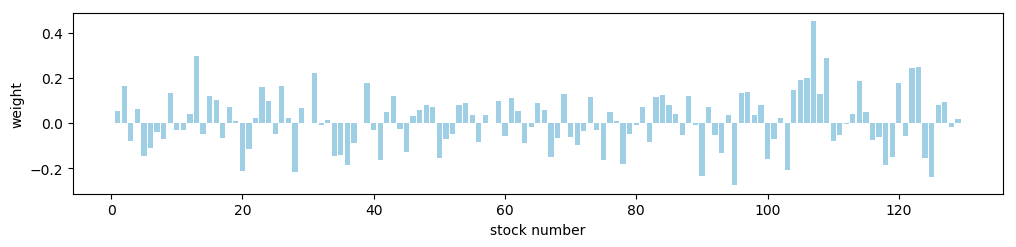

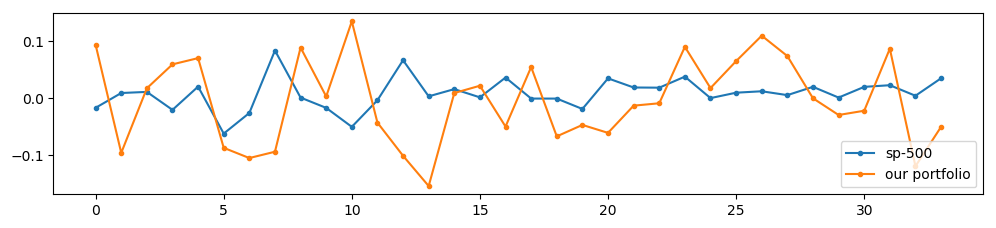

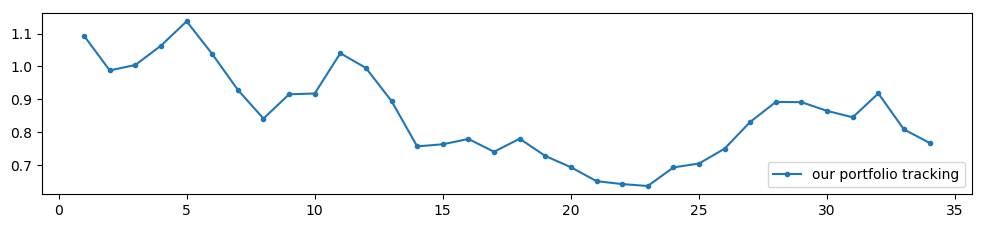

In [96]:
using PyPlot
x = range(1,stop = 129)
fig = figure("pyplot_barplot",figsize=(12,8))
subplot(311)
bar(x,xsol,color="#0f87bf",align="center",alpha=0.4)
xlabel("stock number")
ylabel("weight")

figure(figsize=(12,8))
subplot(312)
plot([sp500_compare_data final_result],".-");
legend(["sp-500", "our portfolio"], loc="lower right");

x = range(1,stop = 34)
figure(figsize=(12,8))
subplot(313)
plot(x, final_tracking,".-");
legend(["our portfolio tracking"], loc="lower right");
;

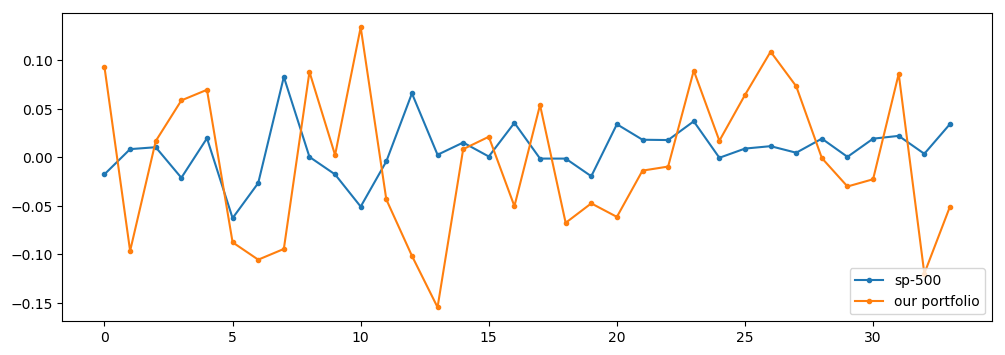

In [88]:
using PyPlot
figure(figsize=(12,4))
plot([sp500_compare_data final_result],".-");
legend(["sp-500", "our portfolio"], loc="lower right");

┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = top-level scope at In[90]:1
└ @ Core In[90]:1
┌ Warning: `haskey(o::PyObject, s::Union{Symbol, AbstractString})` is deprecated, use `hasproperty(o, s)` instead.
│   caller = #plot#85(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::UnitRange{Int64}, ::Vararg{Any,N} where N) at PyPlot.jl:176
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:176


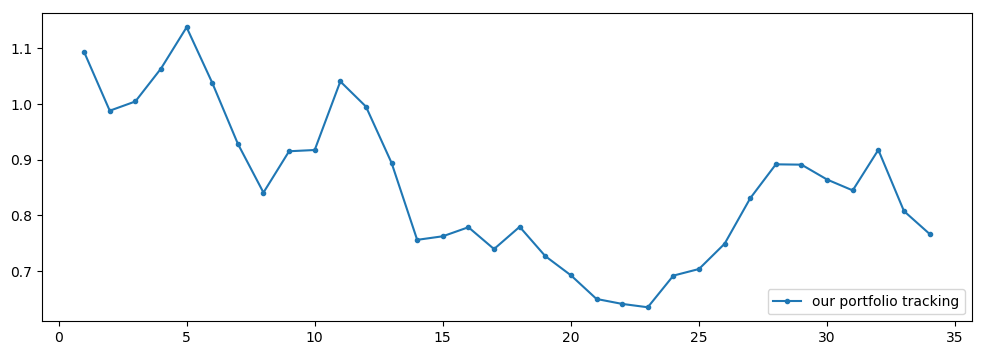

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = #plot#85(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::UnitRange{Int64}, ::Vararg{Any,N} where N) at PyPlot.jl:179
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:179


In [90]:
x = range(1,34)
figure(figsize=(12,4))
plot(x, final_tracking,".-");
legend(["our portfolio tracking"], loc="lower right");